# Model Processing

## Imports & General Settings 

In [1]:
import unittest
import os
import sys
import time
import pathlib

import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
import PIL
from tqdm.notebook import trange, tqdm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, roc_auc_score
from matplotlib import pyplot
from scipy.signal import resample


# Our imports
from data import WaveletTransform, AFECGDataset, SecondDataset, WrapperDataset
import dsp
from model.blocks import ConvNet, BRNN, SoftmaxAttention
from model.baseline import Baseline
from training import train, test
import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
testCase = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Dataset creation

In [4]:
seq_len = 4

In [8]:
dataset_name = 'afdb'
dataset = AFECGDataset(dataset_name, '../data/afdb/', wavelet=WaveletTransform(resample=20), seq_len=seq_len)

In [9]:
# dataset.load(num_records=1)
dataset.load('./temp/' + dataset_name + '_small')

Reading records. sample size=120, frequency=250
torch.Size([7009])
7009


Preprocessing examples: 0it [00:00, ?it/s]/home/michael.me/deep-af-project/src/data.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavelets.append(torch.tensor(sw))
Preprocessing examples: 3it [00:00, 20.91it/s]

Preparing 7009 samples


Preprocessing examples: 7009it [07:00, 16.68it/s]


In [10]:
total_data_size = len(dataset)
print("Total data size: ", total_data_size)
print("Samples with AF: ", dataset.labels.sum().item())
print('Data shape: ', dataset.samples.shape)

Total data size:  7009
Samples with AF:  408
Data shape:  torch.Size([7009, 4, 92, 375])


##  Wavelet Transform

Has AF:  Yes


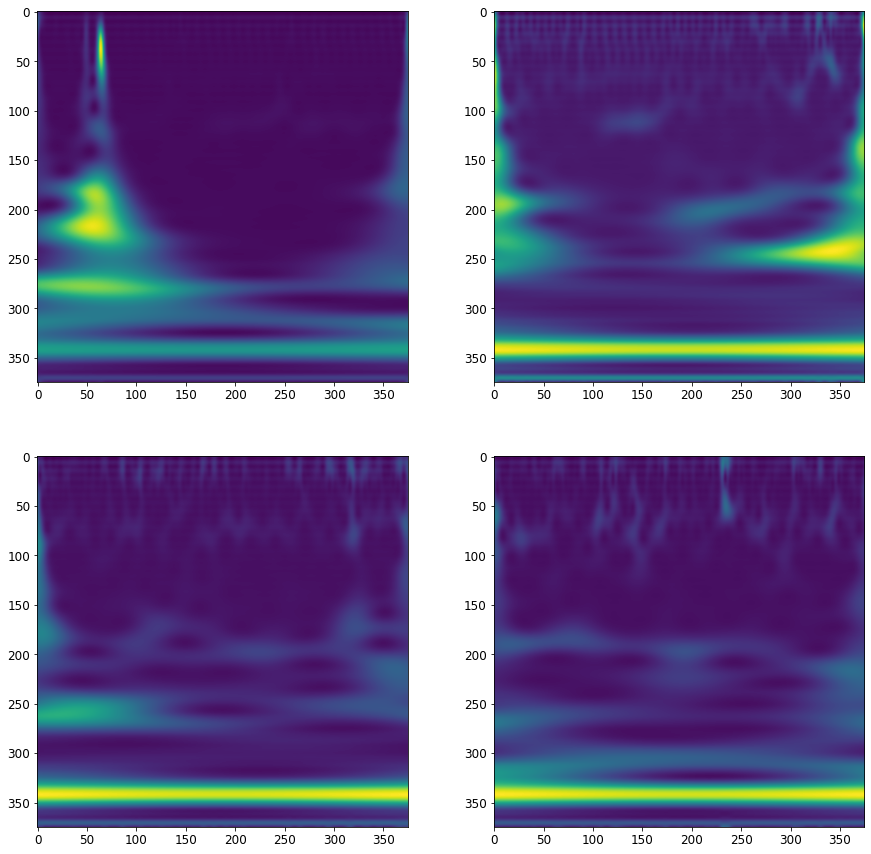

In [24]:
powers, label = dataset[3]
print('Has AF: ', 'Yes' if label == 1 else 'No')

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.reshape(-1)
for power, ax in zip(powers, axes):
    signal = resample(power, 375)
    ax.imshow(signal)

plt.show()

## Training

In [25]:
old_dataset = dataset

true_idx = [i for i, x in enumerate(dataset.labels == 1) if x == True]
false_idx = [i for i, x in enumerate(dataset.labels == 0) if x == True]
print("True idx total, False idx total: ", len(true_idx), len(false_idx))

idxes = true_idx + false_idx[0:len(true_idx)]
print(len(idxes))
dataset = torch.utils.data.Subset(dataset, list(set(idxes)))

True idx total, False idx total:  408 6601
816


In [26]:
heldout = int(len(dataset) * 0.2)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - heldout, heldout])
train_indices = train_dataset.indices
test_indices = test_dataset.indices
# print('[Train] Positive cases = {}'.format((dataset.labels[train_indices] == 1).sum()))
# print('[Test] Positive cases = {}'.format((dataset.labels[test_indices] == 1).sum()))

### Baseline

In [41]:
model = Baseline(seq_len=seq_len)
model = model.to(device)

config = dict(
    num_workers=2,
    batch_size=30,
    learning_rate=0.001,
    weight_decay=0.01,
    num_epochs=20,
    is_notebook=True,
    verbose=True
)

train(model, train_dataset, config)

Ground truth: tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
Ground truth: tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1])
Prediction: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
Ground truth: tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0])
Prediction: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0, 1, 1, 

Ground truth: tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1])
Prediction: tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 1])
Ground truth: tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 1])
Prediction: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
Ground truth: tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1])
Prediction: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0])
Ground truth: tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1])
Prediction: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0, 0, 1, 

Ground truth: tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0])
Prediction: tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0])
Ground truth: tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0])
Prediction: tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1])
Ground truth: tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1])
Prediction: tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1])
Ground truth: tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0])
Prediction: tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0])
Ground truth: tensor([0, 1, 0, 1, 1, 1, 

Ground truth: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1])
Prediction: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0])
Ground truth: tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0])
Prediction: tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0])
Ground truth: tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1])
Prediction: tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1])
Ground truth: tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0])
Prediction: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0])
Ground truth: tensor([0, 0, 1, 1, 1, 1, 

Ground truth: tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1])
Prediction: tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1])
Ground truth: tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0])
Ground truth: tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0])
Prediction: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1])
Ground truth: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0])
Prediction: tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0, 0, 1, 

Ground truth: tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0])
Prediction: tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0])
Ground truth: tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1])
Prediction: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1])
Ground truth: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0])
Prediction: tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1])
Ground truth: tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0])
Prediction: tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0])
Ground truth: tensor([1, 0, 1, 0, 1, 0, 

Ground truth: tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0])
Prediction: tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0])
Ground truth: tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1])
Prediction: tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1])
Ground truth: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0])
Prediction: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0])
Ground truth: tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 1])
Prediction: tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0, 0, 0, 

Ground truth: tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0])
Prediction: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0])
Ground truth: tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1])
Prediction: tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1])
Ground truth: tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0])
Prediction: tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1])
Ground truth: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0])
Prediction: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0])
Ground truth: tensor([0, 0, 1, 0, 1, 0, 

KeyboardInterrupt: 

In [43]:
os.makedirs('./checkpoints')
torch.save({
    'state_dict': model.state_dict(),
    'config': config
}, './checkpoints/baseline.pt')

## Testing

In [44]:
# y_true = dataset.labels[test_dataset.indices]
y_pred, test_acc = test(model, test_dataset, config)

Testing model...


alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
alignment_scores= torch.Size([1, 4])
a

In [45]:
y_true = [y for x, y in test_dataset]

In [46]:
from sklearn import metrics
results = pd.DataFrame(classification_report(y_true, y_pred, zero_division=0, output_dict=True)).transpose()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
auc_score = metrics.auc(fpr, tpr)

In [47]:
display(results)
print("Specificity:", specificity)
print("AUC:", auc_score)

,precision,recall,f1-score,support
0,0.966667,0.630435,0.763158,92.000000
1,0.669903,0.971831,0.793103,71.000000
accuracy,0.779141,0.779141,0.779141,0.779141
macro avg,0.818285,0.801133,0.778131,163.000000
weighted avg,0.837401,0.779141,0.776202,163.000000


Specificity: 0.6304347826086957
AUC: 0.8011328842620943


ROC AUC=0.801


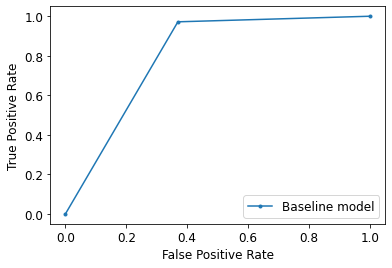

In [48]:
lr_auc = roc_auc_score(y_true, y_pred)
print('ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Baseline model')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [49]:
pr_auc = average_precision_score(y_true, y_pred)
print("PR AUC:", specificity)

PR AUC: 0.6304347826086957
